# Tutorial: Using  Coordinates and Web Scrapping To Identify NYC Neighborhoods with the Best High Schools

Here we are working in Python with a cleaned dataset created with the contents of other small datasets. In summary, the dataset contains information about New York City High Schools ranked by SAT score results average from the year 2012. Along with the scores and other information, the dataset has the geographic coordinates (latitude, longitude) and the DBN (District Borough Number) of each school. Can we use this to find the neighborhood in which each school is located?

With the coordinates we can place each school on a map, and we also know the city borough, but to find the neighborhood, we'll need a map that shows neighborhood names and then try to establish if the school falls within a neighborhood's boundaries. Another way to find the name using the module Geopy is shown in this small tutorial. A web source with all neighborhood names will be used to finish our task, and for that we'll need web scrapping.

## First we import the libraries we need and the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os #The Basemap model if we don't set 'os.environ['PROJ_LIB']'
os.environ['PROJ_LIB'] = 'C:/Users/joman/Anaconda3/Lib/site-packages/mpl_toolkits/basemap'
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim

#Read the data into a pandas dataframe
best_schools_url = 'https://raw.githubusercontent.com/jhmanchola/Learning-curve/master/Problem-Solving/Web-Scraping-for-Missing-Map-Data/best_schools.csv'
best_schools = pd.read_csv(best_schools_url)


## Plot a map just to see how the schools are distributed

C:\Users\joman\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\joman\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


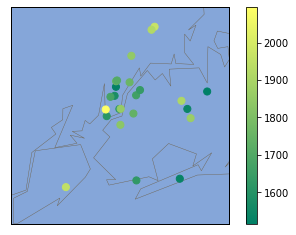

In [2]:
#Get the longitudes and latitudes as list
best_schools_lon =best_schools['lon'].tolist()
best_schools_lat =best_schools['lat'].tolist()

m2 = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m2.drawmapboundary(fill_color='#85A6D9')
m2.drawcoastlines(color='#6D5F47', linewidth=.4)
m2.drawrivers(color='#6D5F47', linewidth=.4)

m2.scatter(best_schools_lon,best_schools_lat,s=50,zorder=2,latlon=True,c=best_schools['sat_score'],cmap="summer")
plt.colorbar()
plt.show()

## Now Geopy will get the information we need
For geopy to work, we need latitude and longitude coordinates in string form, so a new column will be created joinig the string version of 'lat' and 'lon'. Here we'll use the `Nominatum` tool we imported from `geopy.geocoders` at the begining of the process.

Geopy uses geocoding services to get the data it is requesting. Some services are slow and they only allow limited number of requests. That's why there are tools within the module to handle timeouts and allow more requests. More information can be found in the [Geopy documentation.](https://geopy.readthedocs.io/en/latest/#geopy.exc.GeocoderTimedOut) The number of requests will make the code execution somewhat slow.

In [3]:
#create a new column with the coordinates as a string
best_schools["coords"] = best_schools.loc[:,"lat"].astype(str)+','+best_schools.loc[:,"lon"].astype(str)

#Override the default user_agent parameter with a madeup one to prevent deprecation warning
#here the madeup parameter is 'myapp/1', it doesn't mean anything, it's just to please the programming gods
geolocator = Nominatim(user_agent='myapp/1',timeout = 7) #Increase timeout to avoid timeout error
#If timeout parameter doesn't help, use the RateLimiter
#This will allow multiple requests in case of timeouts
from geopy.extra.rate_limiter import RateLimiter 
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1) #Create the object

location_tuples = best_schools['coords'].apply(geocode) #Create a series with the applied function on 'coords'

#Create an example location to see how it works
location = geolocator.reverse("40.761432699000466,-73.98802369799967")
location

Location(322, West 48th Street, Hell's Kitchen, Manhattan Community Board 4, Manhattan, New York County, New York, 10036, United States of America, (40.761279900000005, -73.98818145, 0.0))

With the coordinate (40.761279900000005, -73.98818145) we get a geopy `Location` object that is like a list of identifiers for that location, including the neighborhood name. In this case the neighborhood name is Hell's Kitchen. We can see here that the neighborhood name is the third element in the list, but it turns out this order is very random, and it varies for other locations. So we have to be careful in how we are going to retrive it from the list.

By trial and error, the neighborhood name was always located in between the 2nd and 4th position of the above list. Hence, we'll filter the list by slicing everything in between 1 and 5 or `[1:5]`(a reminder that Python counts the first element as 0 and the slice will exclude the 5). 

In the above code we created a Pandas Series called `location_tuples`. Here we stored all the results of `geocode`. We will create a new series that will take `location_tuples` and apply a function that will split the contents and keep only 4 elements in each row using the slicing already described:

In [4]:
#slice [1:5]
inter_neighborhd = location_tuples.apply(lambda x: x[0].split(', ')[1:5])
inter_neighborhd.head()

0    [Columbia Street, Lower East Side, Manhattan C...
1    [525, East Houston Street, Lower East Side, Ma...
2    [West 48th Street, Hell's Kitchen, Manhattan C...
3          [55, West 25th Street, Penn South, Chelsea]
4    [8th Avenue, Chelsea, Manhattan Community Boar...
Name: coords, dtype: object

## Use Web Scrapping To Find All Neighborhood names

Now that we have the series `inter_neighborhd` with information that includes the neighborhood name for each High School, we can filter that name by doing a web search of all NYC neighborhoods. As it happens, there's a [Wikipedia page](https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City) with all NYC neighborhoods. We will use the package `BeautifulSoup` to scrape just the neighborhood names from the website. We will create a function, `GetandCleanRows()` to get just the text that contains what we want. We will create another function, `getNY_Neighborhoods()` to get just the neighborhood name from that text. At the end of this block of code, we will have a list with all NYC neighborhoods.

In [5]:
#Get list of NY neighborhoods by scrapping the Wikipedia page containing a table of all neighborhoods
from urllib.request import urlopen
from bs4 import BeautifulSoup

url_NYnh = "https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City" #page url

html_NYnh = urlopen(url_NYnh)

NYnh = BeautifulSoup(html_NYnh, 'lxml')

def GetandCleanRows(soup_object):
    '''Utility function to get rows from a table in the website'''

    rows = soup_object.find_all('tr') #Get all rows in table
    row_list = []
    for row in rows: 
        str_cells = str(row.find_all('td')) #Convert each row into a string
        cleantext = BeautifulSoup(str_cells, "lxml").get_text() #Get just the text and remove all html syntax
        row_list.append(cleantext)
    return row_list

NYnh_list = GetandCleanRows(NYnh)
#Create a pandas dataframe, only rows 1 to 60 have relevant info
NY_neighborhoods_df = pd.DataFrame(NYnh_list[1:60]) 

import re
def getNY_Neighborhoods(s):
    '''Function to apply to dataframe, to get just the neighborhood name from string'''
    split = re.split(', |\n]',s)
    return split[4:-1]

#Create new series with results from the getNY_Neighborhoods() function
NY_neighborhoods_series = NY_neighborhoods_df[0].apply(getNY_Neighborhoods) #Apply to column 0
#Create a unique list of neighborhoods by joining all separate lists
NY_neighborhoods = []
for n in NY_neighborhoods_series:
    NY_neighborhoods += n

NY_neighborhoods[:5] # First 5 items in the list

['Melrose', 'Mott Haven', 'Port Morris', 'Hunts Point', 'Longwood']

In the next step, we just need to compare our `NY_neighborhoods` list with the contents of our `inter_neighborhd` series. Remember `inter_neighborhd` has a list of identifiers and among them lies the neighborhood name. We will create a function that will find the neighborhood name when it compares all those identifiers with the contents of `NY_neighborhoods`:

In [6]:
#create the function to select the neighborhood from the list of neighborhood
def getSchoolNeighborhood(s):
    '''Function to get the neighborhood of the school by
    matching the contents of inter_neighborhd with the list of all neighborhoods
    s: a list of 4 items where one of the items is the neighborhood name'''
    for i in s:
        if i in NY_neighborhoods:
            return i
    else:
        return s

#Create a new column in the dataframe 'best_schools' where we store the neighborhood 
#name obtained by applying the above function to the 'inter_neighborhd' series.
best_schools['Neighborhood'] = inter_neighborhd.apply(getSchoolNeighborhood)
best_schools['Neighborhood'].head()

0    Lower East Side
1    Lower East Side
2     Hell's Kitchen
3            Chelsea
4            Chelsea
Name: Neighborhood, dtype: object

## List of Neighborhoods with Best High Schools
A new column `Neighborhood` was created in the `best_schools` dataframe, where we stored the results of applying the function `getSchoolNeighborhood()` to the `inter_neighborhd` series. We printed out the first 5 results of the column and we can see the neighborhood name. Now we only need to do a sorting process to get the neighborhoods with the top high schools according to their SAT score.

In [7]:
#Index only the relevant columns, 'sat_score' and 'Neighborhood'. 
#Group the dataset by neighborhood and calculate the mean of the SAT score for each neighborhood.
#Sort the dataframe according to SAT average score in descending order (High scores first)

best_schools[['sat_score','Neighborhood']].groupby('Neighborhood').mean().sort_values('sat_score',ascending=False)

,sat_score
Neighborhood,
Battery Park City,2096.0
Bedford Park,1969.0
Oakwood,1953.0
Kingsbridge Heights,1920.0
Pomonok,1910.0
Jamaica,1868.0
Hamilton Heights,1847.0
Fort Greene,1833.0
Upper East Side,1758.0


## Conclusion
Just to clarify, the term 'best' to classify a high school is based solely in the SAT score, and there are many opinions against using standarized testing as the only measure of human impact a school has. Nonetheless, this was an exercise to use Geopy and Web scrapping, and we ended with a list of neighborhoods that house the schools with the best SAT scores. We can see Battery Park City has the highest SAT score average (in the dataframe there was only one high school representing Battery Park City, so the average SAT score of the neighborhood is the average for the high school). This neighborhood is located in Manhattan, and as we saw in the map, a lot of good high schools are located in that Borough.